In [5]:
import numpy as np
import os.path
from scipy import ndimage
import itertools
import matplotlib as mpl
import math
import matplotlib.pyplot as plt
import ipdb
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import pandas as pd
pylab.rcParams['figure.figsize'] = (16., 16.)
%matplotlib inline

In [4]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [6]:
#example files
## From Chris' email:
## southern West Africa rainy season:
## MFG (1982-2003), 366x167 grid, MAM, ON, all hours
## MSG (2004-2016), 366x167 grid, MAM, ON, 10 - 1830 UTC only

## JJAS data is on another grid:
## MFG (1982-2003), 546x182 grid, JJAS all hours
## MSG (2004-2016), 546x182 grid, JJAS all hours

met_path = '/home/ck/DIR/cornkle/data/OBS/meteosat_monthly/cold_cloud/cold_cloud/grads/'
mfg_path_JJA = met_path + 'mfg_30min_mean_546_182_200206.gra'
msg_path_JJA = met_path + 'msg_30min_mean_546_182_201506.gra'

mfg_path_SWA = met_path + 'mfg_30min_mean_366_167_199710.gra'
msg_path_SWA = met_path + 'msg_30min_mean_366_167_200711.gra'

In [7]:
## lat_lon_files
ll_path = '/home/ck/DIR/cornkle/data/OBS/meteosat_monthly/cold_cloud/cold_cloud/ll_files/'
ll_file_366 = ll_path + 'common_grid_366_167.gra'
ll_file_546 = ll_path + 'common_grid.gra'

In [8]:
def readLatLon(llfile, nx, ny, nz,nt, nvars):
    
    vars_name = ['mfg_lon', 'msg_lon', 'mfg_lat', 'msg_lat']

    llShape = (nvars, nt, nz, ny, nx) 
    llMDI = np.float32(13.5)
    ll = np.fromfile(llfile,dtype=llMDI.dtype)
    
    ll.shape = llShape
    
    dic = {}
    for ids, var in enumerate(vars_name):
        dic[var] = ll[ids,0,0,:,:]
    
    return dic

In [9]:
# read both coordinate grids
ll_366 = readLatLon(ll_file_366,366,167,1,1,4)
ll_584 = readLatLon(ll_file_546,546,182,1,1,4)

584 lower left 4.891786
366 lower left 4.854769


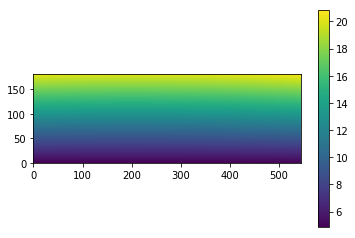

In [10]:
## some testing to check where 366 and 584 grids match up - could be used to cut out to same grid

## coordinates for identical lower left corner of grids, shift same for msg/mfg
print('584 lower left', ll_584['mfg_lat'][0,0])
print('366 lower left',ll_366['msg_lat'][22,14])

## pixel [22,14] in 366 grid corresponds to pixel [0,0] in 584 grid

# grid plot test
plt.imshow(ll_584['mfg_lat'], origin='lower')
plt.colorbar()

In [15]:
def readFile(filepath, lat,lon): 
    if not os.path.isfile(filepath):
        return np.array([False])
    
    var_name = ['val', 'val40', 'val60', 'val70']
    
    month = filepath[-6:-4]
    year = filepath[-10:-6]
    date = pd.date_range(str(year) + '-' + str(month).zfill(2) + '-15 00:00', periods=48, freq='30min')
    
    nt = len(date)
    nvars = len(var_name)
    ny = lat.shape[0]
    nx = lat.shape[1]
    
    rrShape = (nvars, nt, ny, nx)   # file shape
    rrMDI = np.uint8(255)
    rr = np.fromfile(filepath, dtype=rrMDI.dtype)
    
    #ipdb.set_trace()
    
    rr.shape = rrShape
    mlon = lon
    mlat = lat
    
    #dic = {}
    ds = xr.Dataset()
    
    for ids, var in enumerate(var_name):
        #dic[var] = rr[ids,:,:,:]
        
        ds[var] = da = xr.DataArray(rr[ids,:,:,:], 
                                     coords={'time': date, 'lat': (['x', 'y'],lat), 'lon': (['x', 'y'],lat)}, dims=['time','x', 'y'])

    return ds  # dic

In [17]:
lat = ll_366['mfg_lat']
lon = ll_366['mfg_lon']
mfg_dic = readFile(mfg_path_SWA,lat,lon)

In [21]:
lat = ll_366['msg_lat']
lon = ll_366['msg_lon']
msg_dic = readFile(msg_path_SWA,lat,lon)

In [ ]:
## write dataset (e.g. msg_dic) to netcdf
    comp = dict(zlib=True, complevel=5)  # for compressing the data
    encoding = {var: comp for var in msg_dic.data_vars}
    newdat.to_netcdf(path='yourpath/testfile.nc', mode='w', encoding=encoding, format='NETCDF4') #netcdf 4 with compression

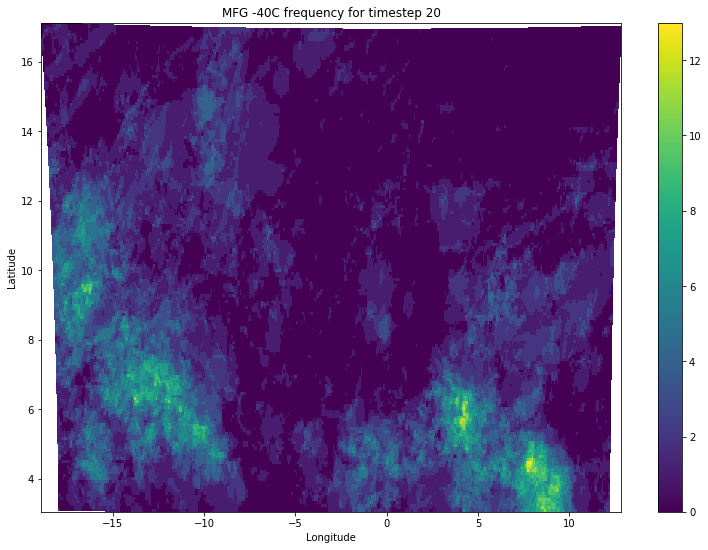

In [178]:
##plot test
plt.figure(figsize=(13,9))
plt.title('MFG -40C frequency for timestep 20')
plt.pcolormesh(mfg_dic['lon'], mfg_dic['lat'], mfg_dic['val40'][20,:,:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

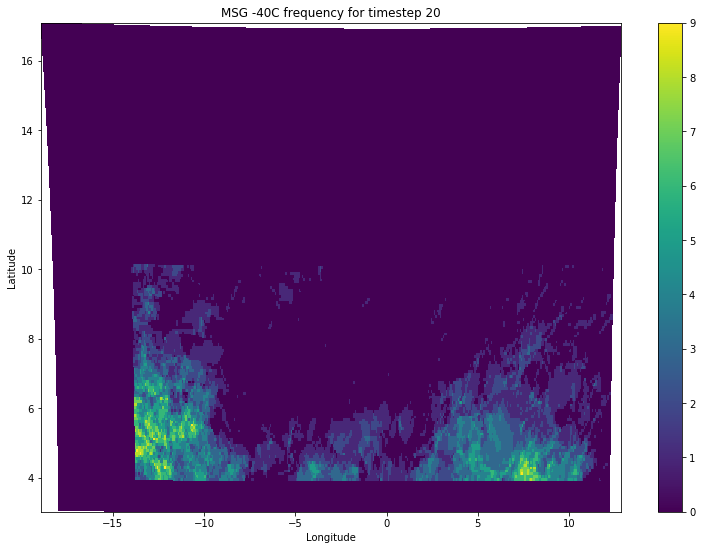

In [187]:
##plot test
plt.figure(figsize=(13,9))
plt.title('MSG -40C frequency for timestep 20')
plt.pcolormesh(msg_dic['lon'], msg_dic['lat'], msg_dic['val40'][20,:,:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

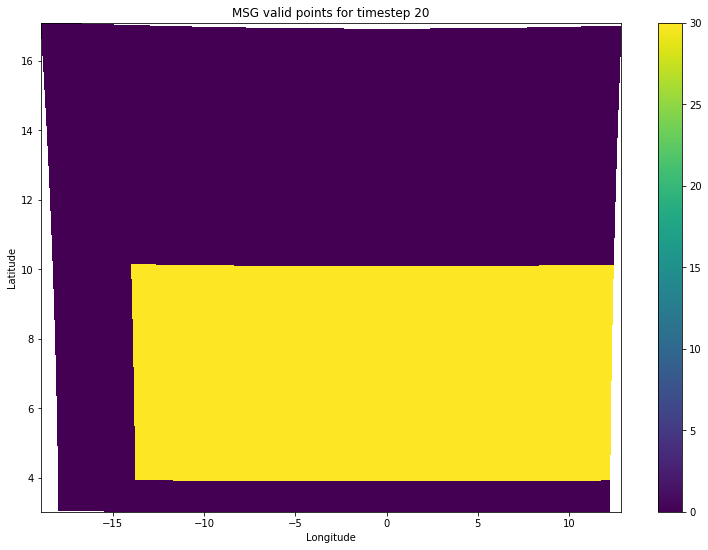

In [189]:
##plot test
plt.figure(figsize=(13,9))
plt.title('MSG valid points for timestep 20')
plt.pcolormesh(msg_dic['lon'], msg_dic['lat'], msg_dic['val'][20,:,:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

In [181]:
lat = ll_584['mfg_lat']
lon = ll_584['mfg_lon']
mfg_dic = readFile(mfg_path_JJA,lat,lon)

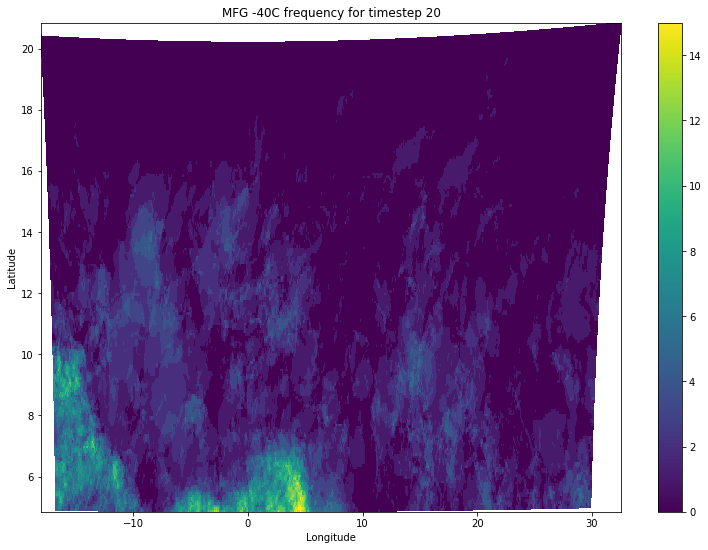

In [182]:
##plot test
plt.figure(figsize=(13,9))
plt.title('MFG -40C frequency for timestep 20')
plt.pcolormesh(mfg_dic['lon'], mfg_dic['lat'], mfg_dic['val40'][20,:,:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

In [183]:
lat = ll_584['msg_lat']
lon = ll_584['msg_lon']
msg_dic = readFile(msg_path_JJA,lat,lon)

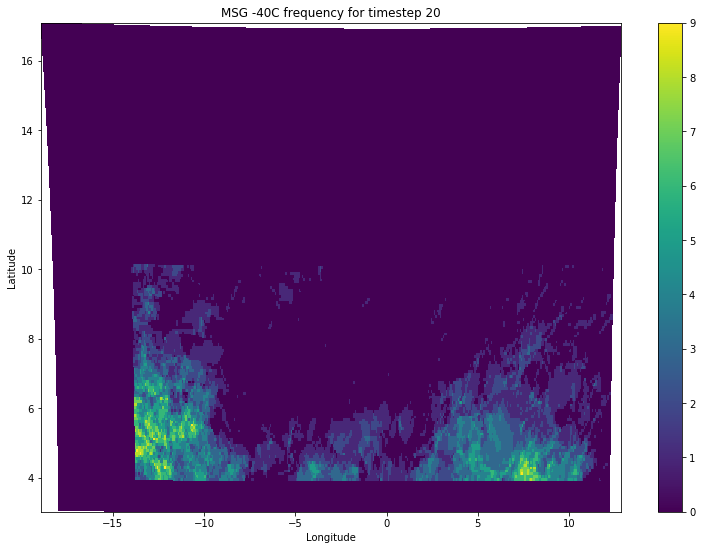

In [184]:
##plot test
plt.figure(figsize=(13,9))
plt.title('MSG -40C frequency for timestep 20')
plt.pcolormesh(msg_dic['lon'], msg_dic['lat'], msg_dic['val40'][20,:,:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()